In [60]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import sys
import cv2

POSTER_FOLDER = "../data/raw/images"
POSTER_SHAPE = (900, 600, 3)
PLOT_FOLDER = "../data/raw/plots/poster_analysis"

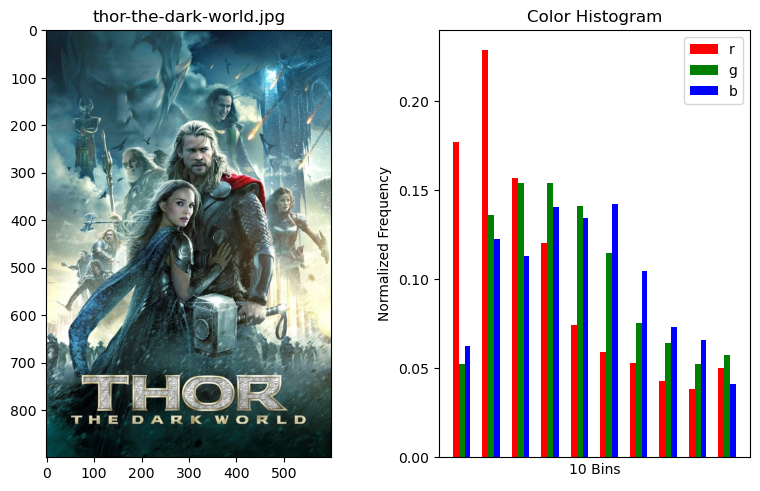

In [69]:
for file in os.listdir(POSTER_FOLDER):
    # print(file)
    # load image into numpy array
    
    image = plt.imread(os.path.join(POSTER_FOLDER, file))
    # print(file, image.shape)
    if image.shape != POSTER_SHAPE:
        sys.exit(1)

    # make plots beside each other
    # ax = plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)

    plt.title(file)


    plt.imshow(image)
    # plt.show()

    # get color histogram
    colors = ('r', 'g', 'b')

    width = 0.2
    for i, col in enumerate(colors):
        hist = cv2.calcHist([image], [i], None, [256], [0, 256])
        
        # convert to bar plot of 10 bins
        hist = np.array([sum(hist[i * 25 : (i + 1) * 25]) for i in range(10)])
        # print(hist.shape)
        # normalize
        hist = hist / sum(hist)
        # flatten array
        hist = hist.flatten()
        indexes = np.arange(10)
        indexes  = indexes + (i * width)
        # print(indexes)
        # plot
        plt.subplot(1, 2, 2)
        plt.bar(indexes, hist, width=width, color=col)
        plt.title("Color Histogram")
        plt.xlabel("10 Bins")
        plt.ylabel("Normalized Frequency")
        # xticks are ranges of 25
        plt.xticks(np.arange(10), np.arange(10) * 25)
        # dont show x ticks
        plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
        # y ticks are percentages
        plt.legend(colors)
        plt.tight_layout()
    
    # make plot wider
    plt.gcf().set_size_inches(8, 5)
    plt.savefig(f"{PLOT_FOLDER}/")
    plt.show()
    

    break
        
       

    

